In [1]:
import keras
import numpy as np
import pickle

Using TensorFlow backend.


In [2]:
from keras import layers
from keras import models
from keras import backend
from keras import optimizers
from keras import regularizers
from sklearn.model_selection import train_test_split

In [4]:
with open('data/data.pkl', 'rb') as f:
    data = pickle.load(f)

x = data['x']
y = data['y']
print(x.shape)
print(y.shape)

NUM_GENRES= y.shape[1]

print(NUM_GENRES)
print(y.sum(axis=0))

(5346, 862, 128)
(5346, 2)
2
[2266. 3080.]


In [6]:
print(np.amax(x))
print(np.amin(x))

6.272013
-96.657776


In [129]:
#x = (x-np.amin(x))/(np.amax(x)-np.amin(x))

In [130]:
print(np.amax(x))
print(np.amin(x))

10.309701
-89.144424


In [5]:
(x_train, x_test, y_train, y_test) = train_test_split(x, y, test_size=0.2,
        random_state=42)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


# How many songs by class
print(y_train.sum(axis=0))
print(y_test.sum(axis=0))

(4276, 862, 128)
(1070, 862, 128)
(4276, 2)
(1070, 2)
[1797. 2479.]
[469. 601.]


Model from deepsound.io

In [6]:
print('Building model...')

n_features = x_train.shape[2]
input_shape = (None, n_features)
model_input = layers.Input(input_shape, name='input')
layer = model_input
for i in range(3):
    # second convolutional layer names are used by extract_filters.py
    layer = layers.Convolution1D(
            filters=256,
            kernel_size=5,
            name='convolution_' + str(i + 1)
        )(layer)
    layer = layers.BatchNormalization(momentum=0.9)(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.MaxPooling1D(2)(layer)
    layer = layers.Dropout(0.5)(layer)

layer = layers.TimeDistributed(layers.Dense(NUM_GENRES))(layer)
time_distributed_merge_layer = layers.Lambda(
        function=lambda x: backend.mean(x, axis=1),
        output_shape=lambda shape: (shape[0],) + shape[2:],
        name='output_merged'
    )
layer = time_distributed_merge_layer(layer)
layer = layers.Activation('softmax', name='output_realtime')(layer)
model_output = layer
model = models.Model(model_input, model_output)
opt = optimizers.Adam(lr=0.001)
model.compile(
        loss='categorical_crossentropy',
        optimizer=opt,
        metrics=['accuracy']
    )

print('Training...')
history = model.fit(
    x_train, y_train, batch_size=32, nb_epoch=100,
    validation_data=(x_test, y_test), verbose=1, callbacks=[
        keras.callbacks.ModelCheckpoint(
            'models/model_salsa.h5', save_best_only=True, monitor='val_acc', verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_acc', factor=0.5, patience=10, min_delta=0.01,
            verbose=1
        )
    ]
)

Building model...
Training...


/home/icesi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 4276 samples, validate on 1070 samples
Epoch 1/100
4276/4276 [==============================] - 15s 4ms/step - loss: 0.7209 - acc: 0.5482 - val_loss: 0.7016 - val_acc: 0.5505

Epoch 00001: val_acc improved from -inf to 0.55047, saving model to models/model_salsa.h5
Epoch 2/100
4276/4276 [==============================] - 4s 824us/step - loss: 0.6849 - acc: 0.5706 - val_loss: 0.6902 - val_acc: 0.5299

Epoch 00002: val_acc did not improve from 0.55047
Epoch 3/100
4276/4276 [==============================] - 4s 826us/step - loss: 0.6835 - acc: 0.5723 - val_loss: 0.6841 - val_acc: 0.5617

Epoch 00003: val_acc improved from 0.55047 to 0.56168, saving model to models/model_salsa.h5
Epoch 4/100
4276/4276 [==============================] - 4s 833us/step - loss: 0.6805 - acc: 0.5674 - val_loss: 0.7318 - val_acc: 0.5617

Epoch 00004: val_acc did not improve from 0.56168
Epoch 5/100
4276/4276 [==============================] - 4s 824us/step - loss: 0.6827 - acc: 0.5669 - val_loss: 0.6965

4276/4276 [==============================] - 4s 821us/step - loss: 0.6113 - acc: 0.6560 - val_loss: 0.8699 - val_acc: 0.4916

Epoch 00042: val_acc did not improve from 0.56636
Epoch 43/100
4276/4276 [==============================] - 4s 822us/step - loss: 0.6076 - acc: 0.6616 - val_loss: 0.9230 - val_acc: 0.4869

Epoch 00043: val_acc did not improve from 0.56636

Epoch 00043: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 44/100
4276/4276 [==============================] - 4s 820us/step - loss: 0.5960 - acc: 0.6705 - val_loss: 0.8781 - val_acc: 0.5439

Epoch 00044: val_acc did not improve from 0.56636
Epoch 45/100
4276/4276 [==============================] - 4s 820us/step - loss: 0.5875 - acc: 0.6810 - val_loss: 0.8199 - val_acc: 0.5336

Epoch 00045: val_acc did not improve from 0.56636
Epoch 46/100
4276/4276 [==============================] - 4s 829us/step - loss: 0.5897 - acc: 0.6833 - val_loss: 0.8046 - val_acc: 0.5178

Epoch 00046: val_acc did not improve f


Epoch 00083: val_acc did not improve from 0.56636

Epoch 00083: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
Epoch 84/100
4276/4276 [==============================] - 4s 827us/step - loss: 0.5257 - acc: 0.7346 - val_loss: 0.8629 - val_acc: 0.5402

Epoch 00084: val_acc did not improve from 0.56636
Epoch 85/100
4276/4276 [==============================] - 4s 824us/step - loss: 0.5288 - acc: 0.7308 - val_loss: 0.8541 - val_acc: 0.5449

Epoch 00085: val_acc did not improve from 0.56636
Epoch 86/100
4276/4276 [==============================] - 4s 830us/step - loss: 0.5236 - acc: 0.7362 - val_loss: 0.8639 - val_acc: 0.5393

Epoch 00086: val_acc did not improve from 0.56636
Epoch 87/100
4276/4276 [==============================] - 4s 844us/step - loss: 0.5318 - acc: 0.7250 - val_loss: 0.8643 - val_acc: 0.5411

Epoch 00087: val_acc did not improve from 0.56636
Epoch 88/100
4276/4276 [==============================] - 4s 828us/step - loss: 0.5282 - acc: 0.7285 - val_loss:

range(0, 100)


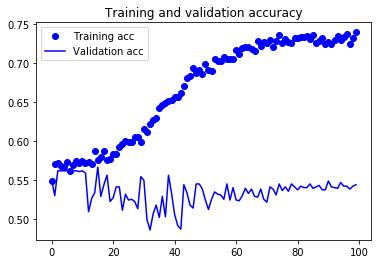

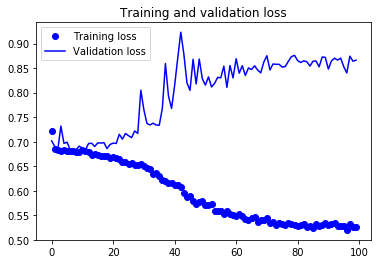

In [9]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

print(epochs)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Maximum validation accuracy in 100 epochs: 0.17715

In [ ]:
model = models.Sequential()
model.add(layers.Convolution1D(256, 5, padding='same',kernel_regularizer=regularizers.l2(0.02),
                        input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(layers.BatchNormalization(momentum=0.9))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Convolution1D(256, 5, padding='same',kernel_regularizer=regularizers.l2(0.02)))
model.add(layers.BatchNormalization(momentum=0.9))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Convolution1D(256, 5, padding='same',kernel_regularizer=regularizers.l2(0.02)))
model.add(layers.BatchNormalization(momentum=0.9))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Dropout(0.2))
model.add(layers.Convolution1D(256, 5, padding='same',kernel_regularizer=regularizers.l2(0.02)))
model.add(layers.BatchNormalization(momentum=0.9))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Dropout(0.2))
model.add(layers.TimeDistributed(layers.Dense(128, activation='relu')))
model.add(layers.Dropout(0.75))
model.add(layers.TimeDistributed(layers.Dense(NUM_GENRES, activation='sigmoid')))
time_distributed_merge_layer = layers.Lambda(
            function=lambda x: backend.mean(x, axis=1),
            output_shape=lambda shape: (shape[0],) + shape[2:],
            name='output_merged'
        )
model.add(time_distributed_merge_layer)

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 862, 256)          164096    
_________________________________________________________________
batch_normalization_8 (Batch (None, 862, 256)          1024      
_________________________________________________________________
activation_8 (Activation)    (None, 862, 256)          0         
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 431, 256)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 431, 256)          327936    
_________________________________________________________________
batch_normalization_9 (Batch (None, 431, 256)          1024      
_________________________________________________________________
activation_9 (Activation)    (None, 431, 256)          0         
__________

In [19]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-4),
              metrics=['acc'])

history = model.fit(x_train, y_train, epochs=100, batch_size=64, validation_split=0.2)

Train on 3420 samples, validate on 856 samples
Epoch 1/100


ResourceExhaustedError: OOM when allocating tensor with shape[64,431,64,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training_4/Adam/gradients/zeros_11-0-1-TransposeNCHWToNHWC-LayoutOptimizer = Transpose[T=DT_FLOAT, Tperm=DT_INT32, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training_4/Adam/gradients/zeros_11, PermConstNCHWToNHWC-LayoutOptimizer)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: metrics_4/acc/Mean/_1343 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1676_metrics_4/acc/Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


range(0, 100)


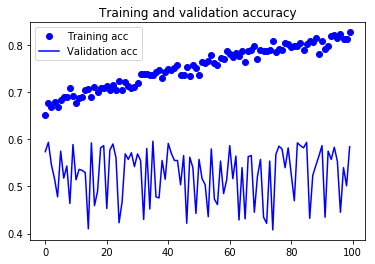

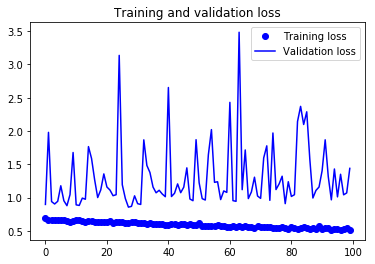

In [14]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

print(epochs)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# x = (x-np.amin(x))/(np.amax(x)-np.amin(x))

In [15]:
x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1)

In [16]:
(x_train, x_test, y_train, y_test) = train_test_split(x, y, test_size=0.2,
        random_state=42)
x_test.shape

(1070, 862, 128, 1)

In [17]:
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), padding='same', name='conv1',
                        input_shape=(x_train.shape[1], x_train.shape[2], 1)))
model.add(layers.BatchNormalization(axis=3, name='bn1'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool1'))
model.add(layers.Dropout(0.1, name='dropout1'))

model.add(layers.Conv2D(128, (3, 3), padding='same', name='conv2'))
model.add(layers.BatchNormalization(axis=3, name='bn2'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(3, 3), name='pool2'))
model.add(layers.Dropout(0.1, name='dropout2'))

model.add(layers.Conv2D(128, (3, 3), padding='same', name='conv3'))
model.add(layers.BatchNormalization(axis=3, name='bn3'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(4, 4), strides=(4, 4), name='pool3'))
model.add(layers.Dropout(0.1, name='dropout3'))

model.add(layers.Flatten())

model.add(layers.Dropout(0.3, name='dropout_final'))

model.add(layers.Dense(NUM_GENRES, activation='softmax', name='output'))

In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 862, 128, 64)      640       
_________________________________________________________________
bn1 (BatchNormalization)     (None, 862, 128, 64)      256       
_________________________________________________________________
activation_17 (Activation)   (None, 862, 128, 64)      0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 431, 64, 64)       0         
_________________________________________________________________
dropout1 (Dropout)           (None, 431, 64, 64)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 431, 64, 128)      73856     
_________________________________________________________________
bn2 (BatchNormalization)     (None, 431, 64, 128)      512       
__________

In [18]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.00000001),
              metrics=['acc'])

history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Train on 3420 samples, validate on 856 samples
Epoch 1/100
3420/3420 [==============================] - 25s 7ms/step - loss: 1.5747 - acc: 0.5570 - val_loss: 0.9891 - val_acc: 0.5876
Epoch 2/100
3420/3420 [==============================] - 23s 7ms/step - loss: 1.5425 - acc: 0.5564 - val_loss: 0.9767 - val_acc: 0.5864
Epoch 3/100
3420/3420 [==============================] - 23s 7ms/step - loss: 1.5581 - acc: 0.5491 - val_loss: 0.9674 - val_acc: 0.5864
Epoch 4/100
3420/3420 [==============================] - 23s 7ms/step - loss: 1.5445 - acc: 0.5544 - val_loss: 0.9582 - val_acc: 0.5876
Epoch 5/100
3420/3420 [==============================] - 24s 7ms/step - loss: 1.5387 - acc: 0.5547 - val_loss: 0.9477 - val_acc: 0.5853
Epoch 6/100
3420/3420 [==============================] - 24s 7ms/step - loss: 1.4816 - acc: 0.5485 - val_loss: 0.9398 - val_acc: 0.5841
Epoch 7/100
3420/3420 [==============================] - 24s 7ms/step - loss: 1.5294 - acc: 0.5336 - val_loss: 0.9310 - val_acc: 0.5841
E

KeyboardInterrupt: 

range(0, 100)


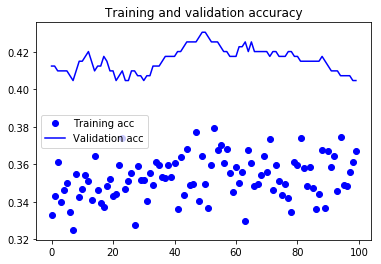

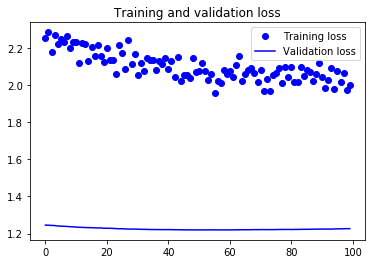

In [36]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

print(epochs)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()